### Importing required libraries

In [ ]:
import numpy as np
import math
import time
import random
import itertools
import queue
import pandas as pd
from IPython.display import display, Markdown

### Reading data
Reading input from document and initializing variables.
You can change dataset variable to 1, 2 or 3 to use different input sets.

In [ ]:
matrix = np.array([
    [34, 20, 57, 47, 62, 40, 74, 94,  9, 62, 86, 13, 78, 46, 83, 52, 13, 70, 40, 60],
    [ 5, 48, 80, 43, 34,  2, 87, 68, 28, 84, 30, 35, 42, 39, 85, 34, 36,  9, 96, 84],
    [86, 35,  5, 93, 74, 12, 40, 95, 80,  6, 92, 14, 83, 49, 36, 38, 43, 89, 94, 33],
    [28, 39, 55, 21, 25, 88, 59, 40, 90, 18, 33, 10, 59, 92, 15, 77, 31, 85, 85, 99],
    [ 8, 91, 45, 55, 75, 18, 59, 86, 45, 89, 11, 54, 38, 41, 64, 98, 83, 36, 61, 19]
])
m=matrix.shape[0]
print(m)
n=matrix.shape[1]
print(n)
cost = np.transpose(matrix)


5
20


# Initialisation
in this method we generate random initiale solutions , and we define a criteria of acceptance depending on  threshold of makespan "initial good solutions"

In [ ]:
def initialization(Npop, upper_bound):
    pop = []
    while len(pop) < Npop:
        p = list(np.random.permutation(n))
        obj_val = calculateObj(p)  # Calculate the objective function value
        if obj_val <= upper_bound:
            pop.append(p)
    return pop


# Calculate Makespan

In [ ]:

def calculateObj(sol):
    qTime = queue.PriorityQueue()

    qMachines = []
    for i in range(m):
        qMachines.append(queue.Queue())

    for i in range(n):
        qMachines[0].put(sol[i])

    busyMachines = []
    for i in range(m):
        busyMachines.append(False)

    time = 0

    job = qMachines[0].get()
    qTime.put((time+cost[job][0], 0, job))
    busyMachines[0] = True

    while True:
        time, mach, job = qTime.get()
        if job == sol[n-1] and mach == m-1:
            break
        busyMachines[mach] = False
        if not qMachines[mach].empty():
                j = qMachines[mach].get()
                qTime.put((time+cost[j][mach], mach, j))
                busyMachines[mach] = True
        if mach < m-1:
            if busyMachines[mach+1] == False:
                qTime.put((time+cost[job][mach+1], mach+1, job))
                busyMachines[mach+1] = True
            else:
                qMachines[mach+1].put(job)
    return time


# Parents selection
in this part we select parents from the population with a propability of p(k)=2k/N(N+1)
where N is the lenght of population , and k is the rank of the current solution pased on it's makespan
we will be selecting N pairs of parents to create N new children


In [ ]:
def selection(pop):
    popObj = []
    for i in range(len(pop)):
        popObj.append([calculateObj(pop[i]), i])

    popObj.sort()

    distr = []
    distrInd = []

    for i in range(len(pop)):
        distrInd.append(popObj[i][1])
        prob = (2*(i+1)) / (len(pop) * (len(pop)+1))
        distr.append(prob)

    parents = []
    for i in range(len(pop)):
        parents.append(list(np.random.choice(distrInd, 2, p=distr)))

    return parents

# Crossover
In the cross over , we select n points , the parts outside of the selected point are ihereted directly fom the first parent , and the rest are ordred depending on their order in the second one
the crossover is applayed with Pc probability

In [ ]:
def crossover(parents):
    pos = list(np.random.permutation(np.arange(n-1)+1)[:2])

    if pos[0] > pos[1]:
        t = pos[0]
        pos[0] = pos[1]
        pos[1] = t

    child = list(parents[0])

    for i in range(pos[0], pos[1]):
        child[i] = -1

    p = -1
    for i in range(pos[0], pos[1]):
        while True:
            p = p + 1
            if parents[1][p] not in child:
                child[i] = parents[1][p]
                break

    return child

# Mutation
in the mutation we select randomly 2 points and we do a shift , the mutation has a probability of Pm

In [ ]:
def mutation(sol):
    pos = list(np.random.permutation(np.arange(n))[:2])

    if pos[0] > pos[1]:
        t = pos[0]
        pos[0] = pos[1]
        pos[1] = t

    remJob = sol[pos[1]]

    for i in range(pos[1], pos[0], -1):
        sol[i] = sol[i-1]

    sol[pos[0]] = remJob

    return sol

# Population update
in this update we will be selecting randomly i element from children to be replaced with low makespan parents

In [ ]:
def elitistUpdate(oldPop, newPop):
    bestSolInd = 0
    bestSol = calculateObj(oldPop[0])

    for i in range(1, len(oldPop)):
        tempObj = calculateObj(oldPop[i])
        if tempObj < bestSol:
            bestSol = tempObj
            bestSolInd = i

    rndInd = random.randint(0,len(newPop)-1)

    newPop[rndInd] = oldPop[bestSolInd]

    return newPop

# Finding the best solution

In [ ]:

def findBestSolution(pop):
    bestObj = calculateObj(pop[0])
    avgObj = bestObj
    bestInd = 0
    for i in range(1, len(pop)):
        tObj = calculateObj(pop[i])
        avgObj = avgObj + tObj
        if tObj < bestObj:
            bestObj = tObj
            bestInd = i

    return bestInd, bestObj, avgObj/len(pop)

# Test One exemple

In [ ]:
#Npop_values = [3, 4, 5, 8, 10, 12]
Npop=3
stopGeneration = 10000
upper = 1450
Pc = 1
Pm = 1

# Initialize an empty list to store the results
results = []

# Run the algorithm for different population sizes
#for Npop in Npop_values:
t1 = time.perf_counter()
population = initialization(Npop, upper)
for i in range(stopGeneration):
    # Selecting parents
        parents = selection(population)
        childs = []

        # Apply crossover
        for p in parents:
            r = random.random()
            if r < Pc:
                childs.append(crossover([population[p[0]], population[p[1]]]))
            else:
                if r < 0.5:
                    childs.append(population[p[0]])
                else:
                    childs.append(population[p[1]])

    # Apply mutation
        for c in childs:
            r = random.random()
            if r < Pm:
                c = mutation(c)

    # Update the population
        population = elitistUpdate(population, childs )



# Stop Timer
t2= time.perf_counter()

# Results Time

bestSol, bestObj, avgObj = findBestSolution(population)

print("Population:")
print(population)
print()

print("Solution:")
print(population[bestSol])
print()

print("Objective Value:")
print(bestObj)
print()

print("Average Objective Value of Population:")
print("%.2f" %avgObj)
print()

print("CPU Time (s)")
timePassed = (t2-t1)
print("%.2f" %timePassed)


Population:
[[16, 1, 15, 8, 13, 11, 7, 18, 6, 17, 9, 4, 12, 19, 3, 2, 0, 14, 5, 10], [12, 9, 8, 16, 1, 11, 13, 0, 10, 19, 18, 15, 3, 7, 6, 4, 17, 14, 2, 5], [5, 13, 9, 7, 8, 16, 1, 0, 10, 19, 18, 15, 11, 3, 6, 17, 4, 12, 14, 2]]

Solution:
[16, 1, 15, 8, 13, 11, 7, 18, 6, 17, 9, 4, 12, 19, 3, 2, 0, 14, 5, 10]

Objective Value:
1206

Average Objective Value of Population:
1415.33

CPU Time (s)
54.62


In [ ]:
deviation = ((1214 - 1206) / 1206) / 100
print(deviation)

6.633499170812604e-05


### Changing Population size

In [ ]:
Npop_values = [3, 4, 5, 8, 10, 15, 25]
stopGeneration = 10000
upper = 1450
Pc = 1.0
Pm = 1.0

# Initialize an empty list to store the results
results = []

# Run the algorithm for different population sizes
for Npop in Npop_values:
    t1 = time.perf_counter()
    population = initialization(Npop, upper)

    for i in range(stopGeneration):
        parents = selection(population)
        childs = []

        for p in parents:
            r = random.random()
            if r < Pc:
                childs.append(crossover([population[p[0]], population[p[1]]]))
            else:
                if r < 0.5:
                    childs.append(population[p[0]])
                else:
                    childs.append(population[p[1]])

        for c in childs:
            r = random.random()
            if r < Pm:
                c = mutation(c)

        population = elitistUpdate(population, childs)

    t2 = time.perf_counter()

    bestSol, bestObj, avgObj = findBestSolution(population)

    timePassed = (t2 - t1)

    # Store the results for this population size
    results.append((Npop, bestObj, avgObj, timePassed))

# Create a DataFrame from the results
df = pd.DataFrame(results, columns=['Pop Size', 'Obj Val', 'Pop Avg Obj', 'CPU Time (s)'])

# Save the DataFrame to a CSV file
df.to_csv('results.csv', index=False)

# Read the generated CSV file
df_read = pd.read_csv('results.csv')

# Display the table
print(df_read)

   Pop Size  Obj Val  Pop Avg Obj  CPU Time (s)
0         3     1226  1282.333333     56.296672
1         4     1216  1333.750000     74.122438
2         5     1219  1517.000000     92.596835
3         8     1217  1636.625000    144.885080
4        10     1241  1598.700000    179.776085
5        15     1264  1641.733333    264.976508
6        25     1255  1671.560000    432.815636


# Changing Probability of crossover and Mutation

In [ ]:
import time
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Npop_values = [4]
stopGeneration = 10000
upper = 1450
Pc_values = [0.8, 0.9, 1.0]  # Different crossover probabilities
Pm_values = [0.4, 0.6, 1.0]  # Different mutation probabilities

# Initialize an empty list to store the results
results = []

# Run the algorithm for different Pc and Pm values
for Pc in Pc_values:
    for Pm in Pm_values:
        for Npop in Npop_values:
            t1 = time.perf_counter()
            population = initialization(Npop, upper)

            for i in range(stopGeneration):
                parents = selection(population)
                childs = []

                for p in parents:
                    r = random.random()
                    if r < Pc:
                        childs.append(crossover([population[p[0]], population[p[1]]]))
                    else:
                        if r < 0.5:
                            childs.append(population[p[0]])
                        else:
                            childs.append(population[p[1]])

                for c in childs:
                    r = random.random()
                    if r < Pm:
                        c = mutation(c)

                population = elitistUpdate(population, childs)

            t2 = time.perf_counter()

            bestSol, bestObj, avgObj = findBestSolution(population)

            timePassed = (t2 - t1)

            # Store the results for this run
            results.append((Npop, Pc, Pm, bestObj, avgObj, timePassed))

# Create a DataFrame from the results
df = pd.DataFrame(results, columns=['Pop Size', 'Pc', 'Pm', 'Obj Val', 'Pop Avg Obj', 'CPU Time (s)'])

# Save the DataFrame to a CSV file
df.to_csv('results_variations.csv', index=False)




   Pop Size   Pc   Pm  Obj Val  Pop Avg Obj  CPU Time (s)
0         4  0.8  0.4     1382      1481.00     70.104485
1         4  0.8  0.6     1406      1489.25     71.584247
2         4  0.8  1.0     1285      1543.75     71.790468
3         4  0.9  0.4     1305      1361.75     71.466901
4         4  0.9  0.6     1356      1444.00     71.360919
5         4  0.9  1.0     1329      1432.50     70.241665
6         4  1.0  0.4     1224      1355.00     71.357295
7         4  1.0  0.6     1226      1486.75     72.944041
8         4  1.0  1.0     1214      1459.25     70.229173


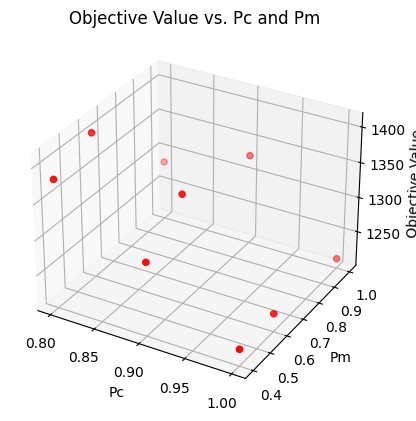

In [ ]:
# Read the generated CSV file
df_read = pd.read_csv('results_variations.csv')
print(df_read)

# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_read['Pc'], df_read['Pm'], df_read['Obj Val'], c='r', marker='o')

# Labels
ax.set_xlabel('Pc')
ax.set_ylabel('Pm')
ax.set_zlabel('Objective Value')

plt.title('Objective Value vs. Pc and Pm')
plt.show()


# Changing the update of Population

In [ ]:
import time
import random
import pandas as pd
import numpy as np

Npop_values = [4]
stopGeneration = 10000
upper = 1450
Pc = 1.0  # Fixed crossover probability
Pm = 1.0  # Fixed mutation probability
numpoints_values = [1,2,3]  # Different number of crossover points

# Initialize an empty list to store the results
results = []

# Run the algorithm for different number of crossover points
for numpoints in numpoints_values:
    for Npop in Npop_values:
            t1 = time.perf_counter()
            population = initialization(Npop, upper)

            for i in range(stopGeneration):
                parents = selection(population)
                childs = []

                for p in parents:
                    r = random.random()
                    if r < Pc:
                        childs.append(crossover([population[p[0]], population[p[1]]]))
                    else:
                        if r < 0.5:
                            childs.append(population[p[0]])
                        else:
                            childs.append(population[p[1]])

                for c in childs:
                    r = random.random()
                    if r < Pm:
                        c = mutation(c)

                population = elitistUpdate(population, childs,numpoints)

            t2 = time.perf_counter()

            bestSol, bestObj, avgObj = findBestSolution(population)

            timePassed = (t2 - t1)

            # Store the results for this run
            results.append((Npop, numpoints , bestObj, avgObj, timePassed))

# Create a DataFrame from the results
df = pd.DataFrame(results, columns=['Pop Size','num points', 'Obj Val', 'Pop Avg Obj', 'CPU Time (s)'])

# Save the DataFrame to a CSV file
df.to_csv('num_points.csv', index=False)



In [ ]:
# Read the generated CSV file
df_read = pd.read_csv('num_points.csv')
print(df_read)


   Pop Size  num points  Obj Val  Pop Avg Obj  CPU Time (s)
0         4           1     1230      1392.50     73.833886
1         4           2     1212      1271.75     71.765550
2         4           3     1226      1263.50     72.306766


# Test 2

In [ ]:
import numpy as np

data = """46 52 79 45 97 10 44 24 85 75 66 49 95 61 19 47 84 13 11 19 98  2 85 44  7 73 19 69 12 73 85 23 53 16 88  8 26 42 58 63  7  2 44 38 24 76 85 61 32 90
 61 87 51 25 73 93 28 90 94 59 64  2 16 35 53 40 81 26 85  4  4 10 63 96 55 71 66 94  7 15 11 99 37 50 56 69 22 56 67 63 96 74  4 42 40 30 93 36 25 87
  3  1 58 85 33 71 58 56 64 43 48 69 96 35 82 53 64 11 61 36 53 87 88 10 32 38 25 24 90  7 11 49  2 76 17 32 39  9 83 69 67 28 88 23 91 71  3 26 41 96
 51 24 21 57 69 51 50 51 21 19 63 91 11  6 31 63 36 39 57 47 56 65 59  4 10 12 62 43 49 54 87 29  2 18 75 39 77 69 15 78 68 37 22 41 92 67 24 87 91 31
 37 16 42 47 94 14 94 34 72 36 88 51 41 71 94 99 11 97 44 77 69 91 38 25 87  7 66 54 86 49  3 48 44 93 37 82 31 59 78 33 36  3 58 10 98  6 44 62 24 94
 79 93 68 75 37 44 34 39 76 62 74 28 78 43 98 83 91 27  6 82 60 44 43 76 99 66 11 35 52  8 40 62 25 24 30  1 73 27 16 91 33 11 99  2 60 90 36 62 15  3
 83 87 38 38 86 67 23 19 97 78 66 67  7 23 67  8 77 71 85 29 49  3 94 76 95 48  4 37 82 57 61  6 97  5 27 95 46 92 46 52  8 11  7 54 72 57 85 22 87 65
 22 29 99 25 98 55 80 82 33 68 47 74 26 61 95 55 11 42 72 14  8 98 90 36 75 69 26 24 55 98 86 30 92 94 66 47  3 41 41 47 89 28 39 80 47 57 74 38 59  5
 27 92 75 94 18 41 37 58 56 20  2 39 91 81 33 14 88 22 36 65 79 23 66  5 15 51  2 81 12 40 59 32 16 87 78 41 43 94  1 93 22 93 62 53 30 34 27 30 54 77
 24 47 39 66 41 46 24 23 68 50 93 22 64 81 94 97 54 82 11 91 23 32 26 22 12 23 34 87 59  2 38 84 62 10 11 93 57 81 10 40 62 49 90 34 11 81 51 21 39 27"""

# Parse the string data into a NumPy array
matrix = np.fromstring(data, sep=' ', dtype=int)
matrix = matrix.reshape(10, -1)  # Reshape the array into a 10x50 matrix
m=matrix.shape[0]
print(m)
n=matrix.shape[1]
print(n)
cost = np.transpose(matrix)

10
50


In [ ]:
#Npop_values = [3, 4, 5, 8, 10, 12]
Npop=4
stopGeneration = 10000
upper = 5000
Pc = 1
Pm = 1

# Initialize an empty list to store the results
results = []

# Run the algorithm for different population sizes
#for Npop in Npop_values:
t1 = time.perf_counter()
population = initialization(Npop, upper)
for i in range(stopGeneration):
    # Selecting parents
        parents = selection(population)
        childs = []

        # Apply crossover
        for p in parents:
            r = random.random()
            if r < Pc:
                childs.append(crossover([population[p[0]], population[p[1]]]))
            else:
                if r < 0.5:
                    childs.append(population[p[0]])
                else:
                    childs.append(population[p[1]])

    # Apply mutation
        for c in childs:
            r = random.random()
            if r < Pm:
                c = mutation(c)

    # Update the population
        population = elitistUpdate(population, childs ,2)



# Stop Timer
t2= time.perf_counter()

# Results Time

bestSol, bestObj, avgObj = findBestSolution(population)

print("Population:")
print(population)
print()

print("Solution:")
print(population[bestSol])
print()

print("Objective Value:")
print(bestObj)
print()

print("Average Objective Value of Population:")
print("%.2f" %avgObj)
print()

print("CPU Time (s)")
timePassed = (t2-t1)
print("%.2f" %timePassed)
# [ 3125        2907]

Population:
[[17, 35, 48, 14, 9, 15, 37, 13, 11, 31, 38, 18, 45, 33, 1, 30, 46, 19, 28, 36, 21, 20, 5, 40, 12, 41, 29, 0, 2, 7, 49, 32, 25, 3, 8, 6, 47, 26, 16, 22, 23, 10, 42, 34, 27, 4, 44, 39, 43, 24], [17, 35, 48, 14, 9, 15, 37, 13, 11, 31, 38, 45, 33, 18, 1, 30, 46, 19, 28, 36, 21, 20, 7, 40, 12, 41, 29, 0, 2, 5, 49, 32, 25, 3, 8, 6, 47, 26, 16, 22, 23, 10, 42, 34, 27, 4, 44, 39, 43, 24], [17, 35, 48, 14, 9, 15, 37, 13, 20, 11, 31, 38, 45, 33, 18, 1, 30, 46, 19, 28, 36, 21, 5, 40, 12, 41, 29, 23, 0, 2, 7, 49, 32, 25, 3, 8, 6, 47, 26, 16, 22, 10, 42, 34, 27, 4, 44, 39, 43, 24], [17, 35, 48, 14, 9, 15, 37, 13, 11, 31, 38, 45, 33, 18, 1, 30, 46, 19, 2, 28, 36, 21, 20, 7, 40, 12, 41, 29, 0, 5, 49, 32, 25, 3, 8, 6, 47, 26, 16, 22, 42, 23, 10, 34, 27, 4, 44, 39, 43, 24]]

Solution:
[17, 35, 48, 14, 9, 15, 37, 13, 11, 31, 38, 18, 45, 33, 1, 30, 46, 19, 28, 36, 21, 20, 5, 40, 12, 41, 29, 0, 2, 7, 49, 32, 25, 3, 8, 6, 47, 26, 16, 22, 23, 10, 42, 34, 27, 4, 44, 39, 43, 24]

Objective Value:

In [ ]:
deviation = ((3193 - 3125 ) / 3125 ) / 100
print(deviation)

0.0002176


# Test 3

In [ ]:
import numpy as np

data = """ 52 95 42 75 44 57 89 53 84 62 91 14 95 89  4 95  2 97 68 20 33 51 98  8 85 86 73  4 40 98 12 59 44 46  2 41 28 83 28 21 80 71  4 60 34 55 53 96 37 37 63 99 69 70 53 21 10 31 80 18  5 18 17 71 90 93 14 49 52  7 78 57 41 75 98 93 33 75 68 33 60 82 24 99  4 97 24 50 55 91 46 58 17 47 82  6 15 91 74 42
 82 21 79 95 46 23 40 95 87 37 24 24 65 62 19 67 66  6 65 59  2 67 82 90 30 63  5 93 53 85 81 73 34 74 13 78 35 20 16 48 12 11 80  9 24 76 32 35 66 48 16 26 46 66 76 31 36  8 37 21  3 76 67  5 47 72 66 56 95 49 47 26 81 56 76 66 36 53 26 52 29 36 68 21 71 61 71 69 28 86 27 41 86 55 17 62 96 59 53 93
 63 55 59 35 21 59 78 25 30 38 78 79 58 44 38 76 70 72 85  8 10 84 42 67 20 24 75 23 33 60 20 75 83 26 92 29 39 14 74 66 86 10 27  8  7 97 84 56 61  9 94 34 89 62 47 66 76 15 18 54 24 55 96 10 12 96 53 92 77  6 91 14 41 30 85 17 23 60 76 39 85 10 65 15 55 41 28 93 88 27 77 81 19 76 55 67 65  8 18 56
 79 21 93 32  8 45 37 78 26 98 17 25 21 28 68 24 62 89 60 64 38 90 87  1 99 34  9 22 74 14 14 84 75 37 32 29 32 89 12 47 19 97  7 12 43 89 14 33 56 57 22  6 24 55 48 57 78  5 50 83 70 21 71 58 36 50 31 86 29 30 93 49 83 89 44 38 62 45 22 85 39 98 56 68 84 77 67 53 46 24 52 96  2 88 33 27 49 78 82 65
 80 13 64 77 17 78 82  4 72 93 68 25 67 80 43 93 21 33 14 30 59 83 85 85 70 35  2 76 46 72 69 46  3 57 71 77 33 49 59 82 59 70 76 10 65 19 77 86 21 75 96  3 50 57 66 84 98 55 70 32 31 64 11  9 32 58 98 95 25  4 45 60 87 31  1 96 22 95 73 77 30 88 14 22 93 48 10  7 14 91  5 43 30 79 39 34 77 81 11 10
 53 19 99 62 88 93 34 72 42 65 39 79  9 26 72 29 36 48 57 95 93 79 88 77 94 39 74 46 17 30 62 77 43 98 48 14 45 25 98 30 90 92 35 13 75 55 80 67  3 93 54 67 25 77 38 98 96 20 15 36 65 97 27 25 61 24 97 61 75 92 73 21 29  3 96 51 26 44 56 31 64 38 44 46 66 31 48 27 82 51 90 63 85 36 69 67 81 18 81 72
 71 90 59 82 22 88 35 49 78 69 76  2 14  3 22 26 44  1  4 16 55 43 87 35 76 98 78 81 48 25 81 27 84 59 98 14 32 95 30 13 68 19 57 65 13 63 26 96 53 94 27 93 49 63 65 34 10 56 51 97 52 46 16 50 96 85 61 76 30 90 42 88 37 43 88 91 14 63 65 74 71  8 39 95 82 17 38 69 17 24 66 75 52 59  4 73 56 19 39 51
 95 53 54 22 84 54  2 80 84 66 25 16 79 90 51 29 29 90 83 83 19 95 87 12 34 23 44 30 82 83 42 56 89 38 96 10  3 53 97 11 65 47 76 22 17 14 11 69 91 53  3 80 78 32 53 43 85 19 48 49 66 22 37 51 82 59 88 77 19 32 52  9 96 23 64 22 37  3 52 44 11 21 85  6 40 68 30 35 58 31 11 11  6 59 64 65 23 80 75 63
 92 62 11 83 87 66 98 42 23 45 52  6  3 64 55 97 83 42 81 92 68 46 56 88 50 13 23 13 49 18 50 94 71 64 31 21  2 63 58 36 64 52  8 94 51 36 82 30 17 21 80 38 55 34 85 44 47 66 19 66 61 60 98 82 79 71 28 74 27 33 13  9 12 51 16 49 83 48 13 78 96 77 68 88 77 76 73 92 72 87 66 98 40 31 75 45 98 90  4 23
 61 86 16 42 14 92 67 77 46 41 78  3 72 95 53 59 34 66 42 63 27 92  8 65 34  6 42 39  2  7 85 32 14 74 59 95 48 37 59  4 42 93 32 30 16 95 58 12 95 21 74 38  4 31 62 39 97 57  9 54 13 47  6 70 19 97 41  1 57 60 62 14 90 76 12 89 37 35 91 69 55 48 56 84 22 51 43 50 62 61 10 87 99 40 91 64 62 53 33 16"""

# Parse the string data into a NumPy array
matrix = np.fromstring(data, sep=' ', dtype=int)
matrix = matrix.reshape(10, -1)  # Reshape the array into a 10x50 matrix
m=matrix.shape[0]
print(m)
n=matrix.shape[1]
print(n)
cost = np.transpose(matrix)

10
100


In [ ]:

Npop=4
stopGeneration = 10000
upper = 6500
Pc = 1
Pm = 1

# Initialize an empty list to store the results
results = []

# Run the algorithm for different population sizes
#for Npop in Npop_values:
t1 = time.perf_counter()
population = initialization(Npop, upper)
for i in range(stopGeneration):
    # Selecting parents
        parents = selection(population)
        childs = []

        # Apply crossover
        for p in parents:
            r = random.random()
            if r < Pc:
                childs.append(crossover([population[p[0]], population[p[1]]]))
            else:
                if r < 0.5:
                    childs.append(population[p[0]])
                else:
                    childs.append(population[p[1]])

    # Apply mutation
        for c in childs:
            r = random.random()
            if r < Pm:
                c = mutation(c)

    # Update the population
        population = elitistUpdate(population, childs ,2)



# Stop Timer
t2= time.perf_counter()

# Results Time

bestSol, bestObj, avgObj = findBestSolution(population)

print("Population:")
print(population)
print()

print("Solution:")
print(population[bestSol])
print()

print("Objective Value:")
print(bestObj)
print()

print("Average Objective Value of Population:")
print("%.2f" %avgObj)
print()

print("CPU Time (s)")
timePassed = (t2-t1)
print("%.2f" %timePassed)
# [5770        5759]

Population:
[[60, 69, 49, 54, 36, 79, 16, 20, 13, 19, 94, 59, 61, 63, 39, 29, 26, 76, 72, 88, 10, 30, 4, 57, 0, 38, 23, 55, 15, 41, 62, 71, 1, 9, 91, 89, 87, 56, 83, 37, 95, 82, 78, 34, 44, 3, 5, 14, 74, 99, 75, 35, 51, 86, 46, 21, 85, 77, 96, 67, 28, 12, 80, 97, 45, 7, 52, 31, 43, 33, 65, 40, 2, 48, 42, 6, 92, 47, 18, 24, 8, 81, 68, 22, 84, 66, 58, 98, 50, 25, 17, 64, 73, 11, 93, 32, 27, 90, 70, 53], [60, 69, 49, 54, 36, 79, 16, 20, 13, 19, 94, 59, 61, 63, 39, 29, 26, 76, 72, 88, 10, 30, 4, 57, 0, 38, 23, 55, 15, 41, 62, 71, 14, 1, 9, 91, 89, 87, 56, 83, 37, 95, 82, 78, 34, 44, 3, 5, 74, 99, 75, 35, 51, 86, 46, 21, 85, 77, 96, 28, 12, 31, 80, 97, 45, 7, 52, 43, 33, 67, 65, 40, 2, 48, 42, 6, 92, 47, 18, 24, 8, 81, 68, 22, 84, 66, 58, 98, 50, 25, 17, 64, 73, 11, 93, 32, 27, 90, 70, 53], [60, 69, 49, 54, 36, 79, 16, 20, 13, 19, 94, 59, 61, 63, 39, 29, 26, 76, 72, 88, 10, 30, 4, 57, 0, 38, 23, 55, 15, 41, 62, 71, 14, 1, 9, 91, 89, 87, 56, 83, 37, 95, 74, 82, 78, 34, 44, 3, 5, 99, 75, 35, 

In [ ]:
deviation = ((6000 - 5770 ) / 5770 ) / 100
print(deviation)

0.00039861351819757364
